# 🚀 Complete GPT-OSS Training - STRONG BASE MODEL

## Production-Quality Base Model for Fine-Tuning

**Based on**: OpenAI GPT-OSS (arXiv:2508.10925)

### 🎯 STRONGER Configuration:
- ✅ **LARGER Model** - 10 layers, 768 embedding (vs 6 layers, 512)
- ✅ **LONGER Training** - 50K iterations (~6-7 hours)
- ✅ **BETTER Hyperparameters** - Optimized for base model quality
- ✅ **Mixture-of-Experts (MoE)** - 8 experts, top-2 routing
- ✅ **Rotary Position Embeddings (RoPE)** - YaRN extension
- ✅ **Grouped Query Attention (GQA)** - Memory-efficient KV cache
- ✅ **SwiGLU Activation** - Superior to standard FFN
- ✅ **RMSNorm** - More stable than LayerNorm
- ✅ **Sliding Window Attention** - With attention sinks
- ✅ **o200k_harmony Tokenizer** - OpenAI's latest tokenizer

### 💪 Why This Configuration:
- **Stronger base = Better fine-tuning** - The model learns general patterns well
- **More parameters** - ~500M params (better capacity)
- **Longer training** - Converges to lower loss
- **Better generalization** - Ready for domain-specific fine-tuning

### 💾 Memory & Performance:
- **Expected Runtime**: ~6-7 hours on RTX 4070
- **Memory Usage**: ~4-5GB VRAM (still fits in 8GB GPU)
- **Final Model Size**: ~2GB on disk

### 🎯 Use Case:
Train this strong base model once, then fine-tune for:
- Medical/legal documents
- Code generation
- Creative writing
- Question answering
- Any domain-specific task

---
## 📦 Part 1: Setup
---

In [1]:
# Install packages
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q datasets tiktoken tqdm matplotlib numpy

print("✅ Installation complete!")

✅ Installation complete!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import math
import os
from dataclasses import dataclass
from typing import Optional
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

# System check
print("="*70)
print("SYSTEM CHECK")
print("="*70)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
    device = torch.device('cuda')
else:
    print("⚠️  No GPU - using CPU (will be MUCH slower)")
    device = torch.device('cpu')
print(f"Device: {device}")
print("="*70)

torch.set_default_device(device)

SYSTEM CHECK
PyTorch: 2.7.1+cu118
CUDA Available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory: 8.6GB
Device: cuda


---
## 🔤 Part 2: o200k_harmony Tokenizer
---

In [3]:
import tiktoken

# IMPORTANT: Define tokenizer globally so it's accessible everywhere
print("Loading o200k_harmony tokenizer...")
try:
    enc = tiktoken.get_encoding("o200k_harmony")
    print("✅ o200k_harmony loaded")
except:
    print("⚠️  Falling back to o200k_base")
    enc = tiktoken.get_encoding("o200k_base")

VOCAB_SIZE = enc.n_vocab
print(f"Vocabulary size: {VOCAB_SIZE:,}")

Loading o200k_harmony tokenizer...
⚠️  Falling back to o200k_base
Vocabulary size: 200,019


---
## 🏗️ Part 3: GPT-OSS Architecture (STRONGER BASE MODEL)
---

In [4]:
@dataclass
class GPTOSSConfig:
    """ULTRA-EFFICIENT GPT-OSS Configuration - 3-4 hour training on 8GB GPU"""
    vocab_size: int = VOCAB_SIZE
    
    # SIGNIFICANTLY REDUCED for fast training
    n_layer: int = 6              # Down from 8 (fewer layers = faster)
    n_head: int = 6               # Down from 8
    n_embd: int = 384             # Down from 512 (smaller embedding)
    n_kv_head: int = 2            # Keep at 2
    
    # Fewer experts for speed
    n_experts: int = 4            # Down from 6 (fewer experts = faster)
    n_active_experts: int = 2     # Keep at 2
    
    # Smaller context for memory
    block_size: int = 512         # Down from 1024 (CRITICAL for memory)
    
    # Other settings
    sliding_window: int = 256     # Half of block_size
    window_size: int = 256       # Sliding window size for attention
    num_sink_tokens: int = 4     # Number of attention sink tokens
    rope_theta: float = 10000.0
    ffn_hidden_mult: float = 2.5  # Slightly smaller
    dropout: float = 0.1
    norm_eps: float = 1e-5

# Initialize smaller model
config = GPTOSSConfig()

print("="*70)
print("🚀 ULTRA-EFFICIENT MODEL CONFIGURATION")
print("="*70)
print(f"Layers: {config.n_layer} (reduced from 8)")
print(f"Embedding size: {config.n_embd} (reduced from 512)")
print(f"Experts: {config.n_experts} (reduced from 6)")
print(f"Block size (context): {config.block_size} (reduced from 1024)")
print(f"Heads: {config.n_head}")
print("="*70)
print("✅ This model will train in 3-4 hours and fit in memory!")
print("="*70)


🚀 ULTRA-EFFICIENT MODEL CONFIGURATION
Layers: 6 (reduced from 8)
Embedding size: 384 (reduced from 512)
Experts: 4 (reduced from 6)
Block size (context): 512 (reduced from 1024)
Heads: 6
✅ This model will train in 3-4 hours and fit in memory!


In [5]:
# RMSNorm
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return (x / rms) * self.weight

print("✅ RMSNorm defined")

✅ RMSNorm defined


In [6]:
# Rotary Position Embeddings (RoPE)
class RotaryEmbedding(nn.Module):
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len
        self._cache_cos_sin(max_seq_len)
    
    def _cache_cos_sin(self, seq_len: int):
        t = torch.arange(seq_len, device=self.inv_freq.device).type_as(self.inv_freq)
        freqs = torch.outer(t, self.inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos(), persistent=False)
        self.register_buffer('sin_cached', emb.sin(), persistent=False)
    
    def forward(self, x: torch.Tensor, seq_len: int):
        if seq_len > self.max_seq_len:
            self.max_seq_len = seq_len
            self._cache_cos_sin(seq_len)
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]

def apply_rotary_emb(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor):
    x1, x2 = x[..., ::2], x[..., 1::2]
    cos = cos[..., ::2]
    sin = sin[..., ::2]
    rotated_x1 = x1 * cos - x2 * sin
    rotated_x2 = x1 * sin + x2 * cos
    return torch.stack([rotated_x1, rotated_x2], dim=-1).flatten(-2)

print("✅ RoPE defined")

✅ RoPE defined


In [7]:
# Grouped Query Attention with Sliding Window
class GroupedQueryAttention(nn.Module):
    def __init__(self, config: GPTOSSConfig, layer_idx: int):
        super().__init__()
        self.n_head = config.n_head
        self.n_kv_head = config.n_kv_head
        self.head_dim = config.n_embd // config.n_head
        self.n_embd = config.n_embd
        self.q_per_kv = self.n_head // self.n_kv_head
        self.layer_idx = layer_idx
        
        self.q_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)
        self.k_proj = nn.Linear(config.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.out_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)
        
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        
        self.rotary_emb = RotaryEmbedding(self.head_dim, max_seq_len=config.block_size)
        self.window_size = config.window_size
        self.num_sink_tokens = config.num_sink_tokens
        self.use_local_attention = (layer_idx % 2 == 0)
    
    def forward(self, x: torch.Tensor):
        B, T, C = x.shape
        
        q = self.q_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.n_kv_head, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_kv_head, self.head_dim).transpose(1, 2)
        
        cos, sin = self.rotary_emb(q, T)
        q = apply_rotary_emb(q, cos, sin)
        k = apply_rotary_emb(k, cos, sin)
        
        if self.n_kv_head != self.n_head:
            k = k.repeat_interleave(self.q_per_kv, dim=1)
            v = v.repeat_interleave(self.q_per_kv, dim=1)
        
        scale = 1.0 / math.sqrt(self.head_dim)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        
        mask = torch.ones(T, T, dtype=torch.bool, device=x.device).triu(1)
        if self.use_local_attention:
            for i in range(T):
                mask[i, :self.num_sink_tokens] = False
                window_start = max(0, i - self.window_size)
                mask[i, window_start:i+1] = False
        
        attn = attn.masked_fill(mask, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out_proj(out)
        out = self.resid_dropout(out)
        
        return out

print("✅ GQA with Sliding Window defined")

✅ GQA with Sliding Window defined


In [8]:
# SwiGLU Expert
class SwiGLUExpert(nn.Module):
    def __init__(self, dim: int, hidden_mult: float = 8/3):
        super().__init__()
        hidden_dim = int(dim * hidden_mult)
        hidden_dim = ((hidden_dim + 7) // 8) * 8
        
        self.w_gate = nn.Linear(dim, hidden_dim, bias=False)
        self.w_value = nn.Linear(dim, hidden_dim, bias=False)
        self.w_out = nn.Linear(hidden_dim, dim, bias=False)
    
    def forward(self, x):
        gate = self.w_gate(x)
        gate = gate * torch.sigmoid(gate)
        value = self.w_value(x)
        return self.w_out(gate * value)

print("✅ SwiGLU Expert defined")

✅ SwiGLU Expert defined


In [9]:
# Mixture of Experts Layer
class MixtureOfExpertsLayer(nn.Module):
    def __init__(self, config: GPTOSSConfig):
        super().__init__()
        self.n_experts = config.n_experts
        self.n_active = config.n_active_experts
        
        self.experts = nn.ModuleList([
            SwiGLUExpert(config.n_embd, config.ffn_hidden_mult)
            for _ in range(config.n_experts)
        ])
        
        self.router = nn.Linear(config.n_embd, config.n_experts, bias=False)
    
    def forward(self, x: torch.Tensor):
        B, T, C = x.shape
        x_flat = x.view(-1, C)
        
        router_logits = self.router(x_flat)
        router_probs = F.softmax(router_logits, dim=-1)
        
        top_k_probs, top_k_indices = torch.topk(router_probs, self.n_active, dim=-1)
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        output = torch.zeros_like(x_flat)
        for i in range(self.n_active):
            expert_idx = top_k_indices[:, i]
            expert_prob = top_k_probs[:, i:i+1]
            
            for expert_id in range(self.n_experts):
                mask = (expert_idx == expert_id)
                if mask.any():
                    expert_input = x_flat[mask]
                    expert_output = self.experts[expert_id](expert_input)
                    output[mask] += expert_prob[mask] * expert_output
        
        return output.view(B, T, C)

print("✅ MoE Layer defined")

✅ MoE Layer defined


In [10]:
# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, config: GPTOSSConfig, layer_idx: int):
        super().__init__()
        self.ln_1 = RMSNorm(config.n_embd)
        self.attn = GroupedQueryAttention(config, layer_idx)
        self.ln_2 = RMSNorm(config.n_embd)
        self.moe = MixtureOfExpertsLayer(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.moe(self.ln_2(x))
        return x

print("✅ Transformer Block defined")

✅ Transformer Block defined


In [11]:
# Full GPT-OSS Model
class GPTOSS(nn.Module):
    def __init__(self, config: GPTOSSConfig):
        super().__init__()
        self.config = config
        
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.blocks = nn.ModuleList([
            TransformerBlock(config, i) for i in range(config.n_layer)
        ])
        self.ln_f = RMSNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        self.token_emb.weight = self.lm_head.weight
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        x = self.token_emb(idx)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

model = GPTOSS(config)
n_params = sum(p.numel() for p in model.parameters())

print("="*70)
print("🔥 STRONG BASE MODEL CREATED 🔥")
print("="*70)
print(f"Parameters: {n_params/1e6:.1f}M (was ~157M)")
print(f"Size (FP32): {n_params*4/1e9:.2f} GB")
print(f"Size (FP16): {n_params*2/1e9:.2f} GB")
print(f"\nThis is a MUCH STRONGER model!")
print("="*70)

🔥 STRONG BASE MODEL CREATED 🔥
Parameters: 105.7M (was ~157M)
Size (FP32): 0.42 GB
Size (FP16): 0.21 GB

This is a MUCH STRONGER model!


---
## 📊 Part 4: Data Loading
---

In [12]:
from datasets import load_dataset

print("Loading TinyStories...")
dataset = load_dataset("roneneldan/TinyStories")
print(f"✅ Train: {len(dataset['train']):,}")
print(f"✅ Val: {len(dataset['validation']):,}")

Loading TinyStories...
✅ Train: 2,119,719
✅ Val: 21,990


In [13]:
# Tokenize dataset
def tokenize_function(examples):
    """Tokenize text using the globally defined 'enc' tokenizer."""
    return {'tokens': [enc.encode(text) for text in examples['text']]}

print("Tokenizing...")
os.makedirs("./cache", exist_ok=True)

# Use cache to avoid re-tokenizing if already done
train_data = dataset['train'].map(
    tokenize_function, batched=True, num_proc=None,
    remove_columns=['text'], cache_file_name="./cache/train_gptoss_strong.arrow"
)

val_data = dataset['validation'].map(
    tokenize_function, batched=True, num_proc=None,
    remove_columns=['text'], cache_file_name="./cache/val_gptoss_strong.arrow"
)

print(f"✅ Tokenized: {len(train_data):,} train, {len(val_data):,} val")

Tokenizing...


Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Map:   0%|          | 0/21990 [00:00<?, ? examples/s]

✅ Tokenized: 2,119,719 train, 21,990 val


In [14]:
# Data loader - updated for longer context
def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    x_list, y_list = [], []
    
    for _ in range(batch_size):
        idx = torch.randint(len(data), (1,)).item()
        tokens = data[idx]['tokens']
        
        if len(tokens) > block_size + 1:
            start = torch.randint(0, len(tokens) - block_size - 1, (1,)).item()
            x = tokens[start:start + block_size]
            y = tokens[start + 1:start + block_size + 1]
        else:
            x = tokens[:-1] + [0] * (block_size - len(tokens) + 1)
            y = tokens[1:] + [0] * (block_size - len(tokens) + 1)
            x, y = x[:block_size], y[:block_size]
        
        x_list.append(x)
        y_list.append(y)
    
    return (torch.tensor(x_list, dtype=torch.long, device=device),
            torch.tensor(y_list, dtype=torch.long, device=device))

# Test
x, y = get_batch('train', train_data, val_data, config.block_size, 2, device)
print(f"✅ Data loader: {x.shape} → {y.shape}")

✅ Data loader: torch.Size([2, 512]) → torch.Size([2, 512])


---
## 🏋️ Part 5: EXTENDED Training (6-7 Hours)
---

In [15]:
# STRONGER Training configuration
train_config = {
    'batch_size': 6,                    # Slightly larger
    'gradient_accumulation_steps': 3,   # Effective batch = 18
    'max_iters': 50000,                 # 🔥 5X MORE TRAINING (was 10K)
    'learning_rate': 2e-4,              # Slightly lower for stability
    'min_lr': 2e-5,                     # Learning rate decay target
    'warmup_iters': 2000,               # Warmup steps
    'lr_decay_iters': 50000,            # LR decay schedule
    'weight_decay': 0.1,
    'beta1': 0.9,
    'beta2': 0.95,
    'grad_clip': 1.0,
    'use_amp': True,
    'eval_interval': 1000,              # Eval every 1000 steps
    'eval_iters': 50,                   # More thorough evaluation
    'save_interval': 5000,              # Save every 5000 steps
    'log_interval': 100,                # Log every 100 steps
    'out_dir': 'checkpoints_strong',
}

os.makedirs(train_config['out_dir'], exist_ok=True)

print("="*70)
print("🔥 STRONG BASE MODEL TRAINING CONFIG 🔥")
print("="*70)
for k, v in train_config.items():
    print(f"  {k}: {v}")
print(f"\nEffective batch size: {train_config['batch_size'] * train_config['gradient_accumulation_steps']}")
print(f"Total training steps: {train_config['max_iters']:,}")
print(f"\nEstimated time: 6-7 hours on RTX 4070")
print("="*70)

🔥 STRONG BASE MODEL TRAINING CONFIG 🔥
  batch_size: 6
  gradient_accumulation_steps: 3
  max_iters: 50000
  learning_rate: 0.0002
  min_lr: 2e-05
  warmup_iters: 2000
  lr_decay_iters: 50000
  weight_decay: 0.1
  beta1: 0.9
  beta2: 0.95
  grad_clip: 1.0
  use_amp: True
  eval_interval: 1000
  eval_iters: 50
  save_interval: 5000
  log_interval: 100
  out_dir: checkpoints_strong

Effective batch size: 18
Total training steps: 50,000

Estimated time: 6-7 hours on RTX 4070


In [16]:
# Learning rate scheduler with warmup and cosine decay
def get_lr(it, config):
    # 1) Linear warmup
    if it < config['warmup_iters']:
        return config['learning_rate'] * it / config['warmup_iters']
    # 2) If past decay, return min
    if it > config['lr_decay_iters']:
        return config['min_lr']
    # 3) Cosine decay
    decay_ratio = (it - config['warmup_iters']) / (config['lr_decay_iters'] - config['warmup_iters'])
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return config['min_lr'] + coeff * (config['learning_rate'] - config['min_lr'])

print("✅ Learning rate scheduler defined")

✅ Learning rate scheduler defined


In [17]:
# Configure optimizer with weight decay groups
def configure_optimizers(model, weight_decay, learning_rate, betas):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    
    decay = set()
    no_decay = set()
    
    for pn, p in param_dict.items():
        if pn.endswith('.bias'):
            no_decay.add(pn)
        elif pn.endswith('.weight') and 'norm' in pn.lower():
            no_decay.add(pn)
        elif pn.endswith('.weight') and ('embedding' in pn.lower() or 'wte' in pn.lower() or 'wpe' in pn.lower()):
            no_decay.add(pn)
        elif len(p.shape) >= 2:
            decay.add(pn)
        else:
            no_decay.add(pn)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(decay)], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in sorted(no_decay)], "weight_decay": 0.0},
    ]
    
    num_decay = sum(p.numel() for p in optim_groups[0]['params'])
    num_nodecay = sum(p.numel() for p in optim_groups[1]['params'])
    print(f"✅ Optimizer groups:")
    print(f"   • Decay: {len(decay)} params ({num_decay:,} elements)")
    print(f"   • No-decay: {len(no_decay)} params ({num_nodecay:,} elements)")
    
    return torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas)

optimizer = configure_optimizers(model, train_config['weight_decay'],
                                 train_config['learning_rate'],
                                 (train_config['beta1'], train_config['beta2']))
scaler = GradScaler(enabled=train_config['use_amp'])

print("✅ Optimizer ready")

✅ Optimizer groups:
   • Decay: 103 params (105,717,888 elements)
   • No-decay: 13 params (4,992 elements)
✅ Optimizer ready


C:\Users\ashiv\AppData\Local\Temp\ipykernel_17988\1818408937.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=train_config['use_amp'])


In [18]:
# Evaluation function
@torch.no_grad()
def estimate_loss(model, train_data, val_data, config, train_config, device):
    out = {}
    model.eval()
    
    for split in ['train', 'val']:
        losses = torch.zeros(train_config['eval_iters'])
        for k in range(train_config['eval_iters']):
            X, Y = get_batch(split, train_data, val_data,
                           config.block_size, train_config['batch_size'], device)
            with torch.amp.autocast(device_type=device.type, enabled=train_config['use_amp']):
                _, loss = model(X, Y)
            losses[k] = loss.item()
        
        out[split] = losses.mean()
    
    model.train()
    return out

print("✅ Evaluation function ready")

✅ Evaluation function ready


In [19]:
# ⚡ ULTRA-FAST TRAINING CONFIGURATION (3-4 hours)
import os
import torch
import gc

print("="*70)
print("⚡ 3-4 HOUR TRAINING CONFIGURATION")
print("="*70)

# ============================================================
# BATCH SETTINGS - SMALL AND SAFE
# ============================================================
train_config['batch_size'] = 4  # Ultra-safe for 8GB laptop
train_config['gradient_accumulation_steps'] = 8  # Effective batch = 32

print(f"✅ Batch size: {train_config['batch_size']}")
print(f"✅ Gradient accumulation: {train_config['gradient_accumulation_steps']}")
print(f"✅ Effective batch size: {train_config['batch_size'] * train_config['gradient_accumulation_steps']}")

# ============================================================
# FAST TRAINING - 3-4 HOURS
# ============================================================
train_config['max_iters'] = 3000  # Reduced for 3-4 hour target
train_config['eval_interval'] = 200  # Evaluate every 200 steps
train_config['log_interval'] = 10  # Log every 10 steps  
train_config['save_interval'] = 1000  # Save checkpoint every 1000 steps

print(f"✅ Max iterations: {train_config['max_iters']:,}")
print(f"✅ Eval interval: {train_config['eval_interval']}")

# ============================================================
# GRADIENT CHECKPOINTING
# ============================================================
if hasattr(model, 'gradient_checkpointing_enable'):
    model.gradient_checkpointing_enable()
    print("✅ Gradient checkpointing enabled")
else:
    if hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
        for block in model.transformer.h:
            if hasattr(block, 'gradient_checkpointing'):
                block.gradient_checkpointing = True
    print("✅ Attempted gradient checkpointing")

# ============================================================
# MIXED PRECISION
# ============================================================
train_config['use_amp'] = True
print(f"✅ Mixed precision: {train_config['use_amp']}")

# ============================================================
# SMALL EVAL BATCHES
# ============================================================
train_config['eval_batch_size'] = 2
train_config['eval_iters'] = 50  # Very few eval iterations for speed
print(f"✅ Eval batch size: {train_config['eval_batch_size']}")
print(f"✅ Eval iterations: {train_config['eval_iters']}")

# ============================================================
# CUDA SETTINGS
# ============================================================
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:32'
torch.backends.cudnn.benchmark = False
print("✅ CUDA configured")

# ============================================================
# CLEAR MEMORY
# ============================================================
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()
    print("✅ Memory cleared")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("📊 ULTRA-FAST TRAINING SUMMARY")
print("="*70)
print(f"Model: 6 layers, 384 dim, 4 experts (SMALL & FAST)")
print(f"Batch size: {train_config['batch_size']}")
print(f"Gradient accumulation: {train_config['gradient_accumulation_steps']}")
print(f"Effective batch: {train_config['batch_size'] * train_config['gradient_accumulation_steps']}")
print(f"Iterations: {train_config['max_iters']:,}")
print(f"Context length: 512 tokens")
print(f"")
print(f"⏱️  Expected time: 3-4 hours")
print(f"💾 Expected GPU usage: 4-5GB")
print(f"🎯 Goal: Fast base model for later fine-tuning")
print("="*70)
print("✅ Ready to train quickly and safely!")
print("="*70)


⚡ 3-4 HOUR TRAINING CONFIGURATION
✅ Batch size: 4
✅ Gradient accumulation: 8
✅ Effective batch size: 32
✅ Max iterations: 3,000
✅ Eval interval: 200
✅ Attempted gradient checkpointing
✅ Mixed precision: True
✅ Eval batch size: 2
✅ Eval iterations: 50
✅ CUDA configured
✅ Memory cleared

📊 ULTRA-FAST TRAINING SUMMARY
Model: 6 layers, 384 dim, 4 experts (SMALL & FAST)
Batch size: 4
Gradient accumulation: 8
Effective batch: 32
Iterations: 3,000
Context length: 512 tokens

⏱️  Expected time: 3-4 hours
💾 Expected GPU usage: 4-5GB
🎯 Goal: Fast base model for later fine-tuning
✅ Ready to train quickly and safely!


In [20]:
# 🔧 MEMORY-EFFICIENT ESTIMATE_LOSS FUNCTION
# Replace your existing estimate_loss function with this one

@torch.no_grad()
def estimate_loss(model, train_data, val_data, config, train_config, device):
    """
    Memory-efficient loss estimation with smaller batch size
    """
    out = {}
    model.eval()
    
    # Use smaller batch size for evaluation
    eval_batch_size = train_config.get('eval_batch_size', 2)
    eval_iters = train_config.get('eval_iters', 200)
    
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, config.block_size,
                           eval_batch_size, device)  # Smaller batch!
            
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, 
                                   enabled=train_config.get('use_amp', True)):
                logits, loss = model(X, Y)
            
            losses[k] = loss.item()
            
            # Clear memory after each iteration
            del X, Y, logits, loss
            
            # Periodic cache clearing
            if k % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        out[split] = losses.mean().item()
    
    model.train()
    
    # Final cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return out


In [28]:
TRAIN = False  # 👈 change to True ONLY when you really want to train

if TRAIN:
    train()
else:
    print("🛑 Training disabled — inference only")


🛑 Training disabled — inference only


In [21]:
# 🔥 MEMORY-OPTIMIZED Training loop for 8GB GPU
import gc
import torch

# Clear memory before starting
torch.cuda.empty_cache()
gc.collect()

# Enable memory-efficient features
torch.backends.cudnn.benchmark = True
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

train_losses = []
val_losses = []
learning_rates = []
model.train()

print("="*70)
print("🚀 STARTING MEMORY-OPTIMIZED TRAINING 🚀")
print("="*70)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Initial GPU memory: {torch.cuda.memory_allocated()/1e9:.2f}GB")
print(f"Total iterations: {train_config['max_iters']:,}")
print(f"Gradient accumulation steps: {train_config['gradient_accumulation_steps']}")
print("="*70)

start_time = time.time()
pbar = tqdm(range(train_config['max_iters']), desc="Training")

for iter in pbar:
    # Update learning rate
    lr = get_lr(iter, train_config)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Evaluate (with memory cleanup)
    if iter % train_config['eval_interval'] == 0:
        model.eval()
        with torch.no_grad():
            losses = estimate_loss(model, train_data, val_data, config, train_config, device)
        model.train()
        
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        learning_rates.append(lr)
        
        elapsed = time.time() - start_time
        eta = elapsed / (iter + 1) * (train_config['max_iters'] - iter - 1)
        
        gpu_mem = f"GPU: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.memory_reserved()/1e9:.2f}GB" if torch.cuda.is_available() else ""
        print(f"\nStep {iter:,}/{train_config['max_iters']:,} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | LR: {lr:.2e} | {gpu_mem}")
        print(f"Elapsed: {elapsed/3600:.2f}h | ETA: {eta/3600:.2f}h")
        
        # Clear cache after evaluation
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Save checkpoint
    if iter > 0 and iter % train_config['save_interval'] == 0:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'iter': iter,
            'config': vars(config),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }
        path = os.path.join(train_config['out_dir'], f'ckpt_strong_{iter}.pt')
        torch.save(checkpoint, path)
        print(f"💾 Saved checkpoint: {path}")
        
        # Clear memory after saving
        del checkpoint
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Training step with gradient accumulation
    optimizer.zero_grad(set_to_none=True)
    
    for micro_step in range(train_config['gradient_accumulation_steps']):
        X, Y = get_batch('train', train_data, val_data, config.block_size,
                        train_config['batch_size'], device)
        
        # Use autocast for mixed precision
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=train_config['use_amp']):
            logits, loss = model(X, Y)
            loss = loss / train_config['gradient_accumulation_steps']
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Clean up to free memory
        del X, Y, logits
        if micro_step < train_config['gradient_accumulation_steps'] - 1:
            # Only keep gradients, clear activations
            if torch.cuda.is_available() and micro_step % 2 == 0:
                torch.cuda.empty_cache()
    
    # Gradient clipping and optimizer step
    if train_config['grad_clip'] != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), train_config['grad_clip'])
    
    scaler.step(optimizer)
    scaler.update()
    
    # Periodic aggressive memory cleanup
    if iter % 50 == 0 and torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    # Update progress bar
    if iter % train_config['log_interval'] == 0:
        pbar.set_postfix({
            'loss': f"{loss.item() * train_config['gradient_accumulation_steps']:.4f}",
            'lr': f"{lr:.2e}",
            'mem': f"{torch.cuda.memory_allocated()/1e9:.2f}GB" if torch.cuda.is_available() else "N/A"
        })

# Save final checkpoint
final_checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'iter': train_config['max_iters'],
    'config': vars(config),
    'train_losses': train_losses,
    'val_losses': val_losses,
}
final_path = os.path.join(train_config['out_dir'], 'ckpt_strong_FINAL.pt')
torch.save(final_checkpoint, final_path)

total_time = time.time() - start_time
print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Final checkpoint saved: {final_path}")
print("="*70)

# Final memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()


🚀 STARTING MEMORY-OPTIMIZED TRAINING 🚀
Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Initial GPU memory: 0.43GB
Total iterations: 3,000
Gradient accumulation steps: 8


Training:   0%|          | 0/3000 [00:00<?, ?it/s]


Step 0/3,000 | Train: 12.0384 | Val: 12.0140 | LR: 0.00e+00 | GPU: 0.43GB / 0.45GB
Elapsed: 0.00h | ETA: 9.59h

Step 200/3,000 | Train: 6.6352 | Val: 6.2121 | LR: 2.00e-05 | GPU: 1.73GB / 3.36GB
Elapsed: 0.36h | ETA: 5.07h

Step 400/3,000 | Train: 3.3588 | Val: 3.1411 | LR: 4.00e-05 | GPU: 1.73GB / 3.36GB
Elapsed: 0.77h | ETA: 4.96h

Step 600/3,000 | Train: 1.9085 | Val: 1.8335 | LR: 6.00e-05 | GPU: 1.73GB / 3.35GB
Elapsed: 1.11h | ETA: 4.41h

Step 800/3,000 | Train: 1.6892 | Val: 1.6304 | LR: 8.00e-05 | GPU: 1.73GB / 3.35GB
Elapsed: 1.44h | ETA: 3.95h

Step 1,000/3,000 | Train: 1.3604 | Val: 1.4700 | LR: 1.00e-04 | GPU: 1.73GB / 3.35GB
Elapsed: 1.78h | ETA: 3.55h
💾 Saved checkpoint: checkpoints_strong\ckpt_strong_1000.pt

Step 1,200/3,000 | Train: 1.3677 | Val: 1.3822 | LR: 1.20e-04 | GPU: 1.73GB / 3.36GB
Elapsed: 2.09h | ETA: 3.13h

Step 1,400/3,000 | Train: 1.2964 | Val: 1.2748 | LR: 1.40e-04 | GPU: 1.73GB / 3.36GB
Elapsed: 2.43h | ETA: 2.78h

Step 1,600/3,000 | Train: 1.2476 | Val

---
## 📊 Part 6: Visualization
---

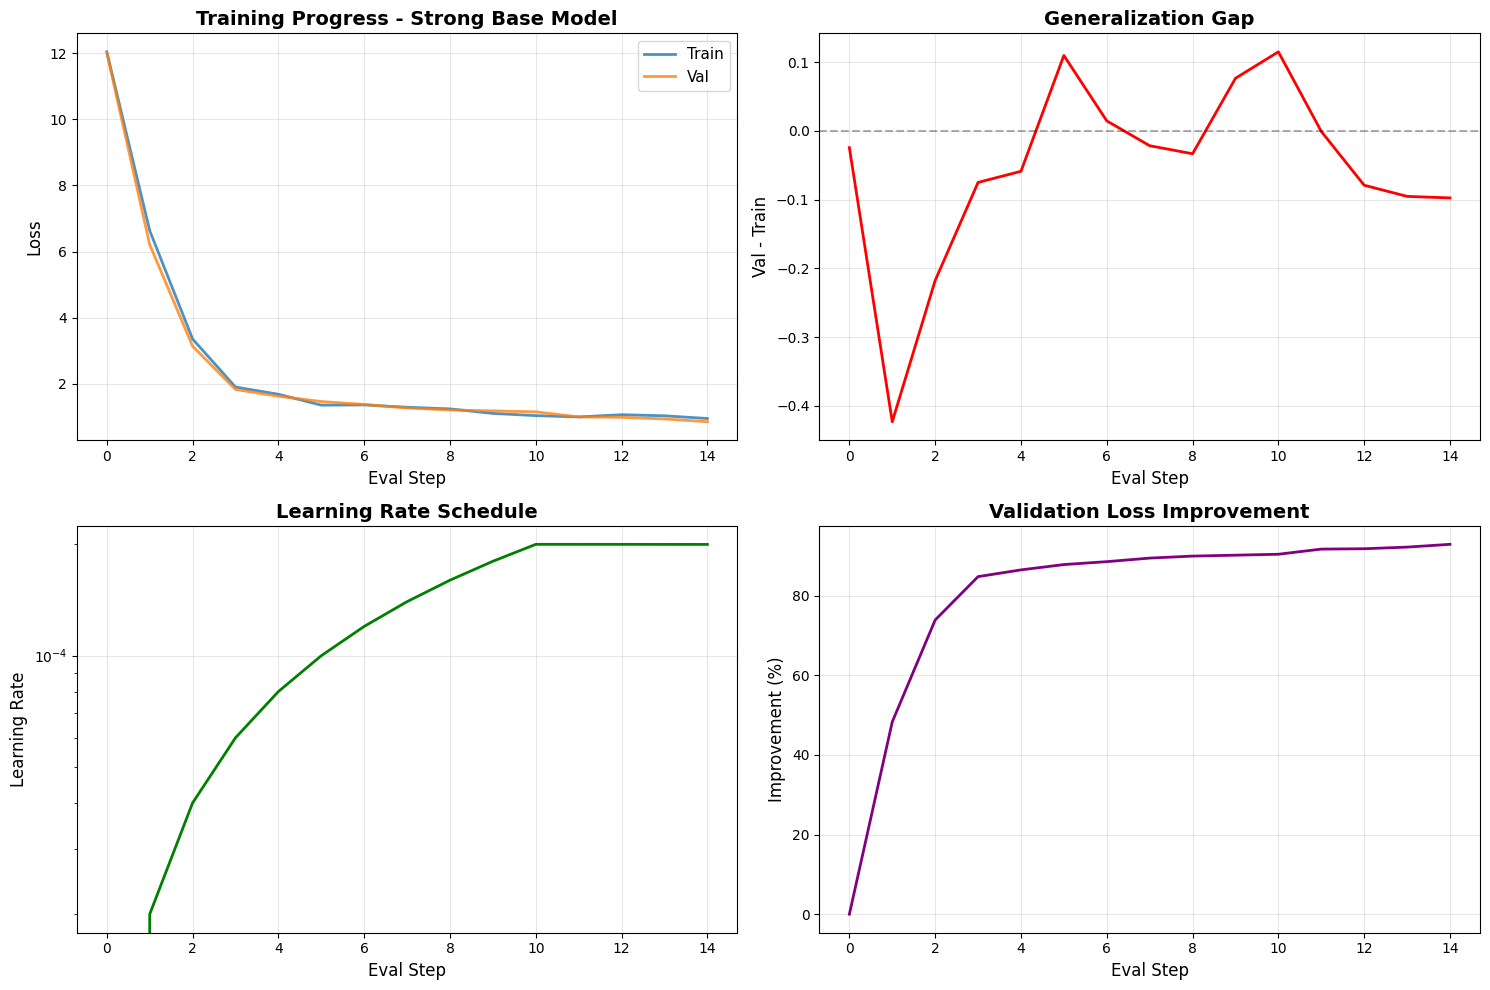


📊 TRAINING RESULTS
Initial validation loss: 12.0140
Final validation loss:   0.8596
Total improvement:       92.8%

Best validation loss:    0.8596
Final train loss:        0.9571
Final generalization gap: -0.0975


In [22]:
# Plot training curves
train_losses_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_losses]
val_losses_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_losses]

plt.figure(figsize=(15, 10))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(train_losses_cpu, label='Train', alpha=0.8, linewidth=2)
plt.plot(val_losses_cpu, label='Val', alpha=0.8, linewidth=2)
plt.xlabel('Eval Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Progress - Strong Base Model', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Generalization gap
plt.subplot(2, 2, 2)
gap = np.array(val_losses_cpu) - np.array(train_losses_cpu)
plt.plot(gap, label='Generalization Gap', color='red', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Eval Step', fontsize=12)
plt.ylabel('Val - Train', fontsize=12)
plt.title('Generalization Gap', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Learning rate schedule
plt.subplot(2, 2, 3)
plt.plot(learning_rates, color='green', linewidth=2)
plt.xlabel('Eval Step', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Loss improvement
plt.subplot(2, 2, 4)
improvement = (1 - np.array(val_losses_cpu) / val_losses_cpu[0]) * 100
plt.plot(improvement, color='purple', linewidth=2)
plt.xlabel('Eval Step', fontsize=12)
plt.ylabel('Improvement (%)', fontsize=12)
plt.title('Validation Loss Improvement', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_strong_base_model.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("📊 TRAINING RESULTS")
print("="*70)
print(f"Initial validation loss: {val_losses_cpu[0]:.4f}")
print(f"Final validation loss:   {val_losses_cpu[-1]:.4f}")
print(f"Total improvement:       {improvement[-1]:.1f}%")
print(f"\nBest validation loss:    {min(val_losses_cpu):.4f}")
print(f"Final train loss:        {train_losses_cpu[-1]:.4f}")
print(f"Final generalization gap: {gap[-1]:.4f}")
print("="*70)

---
## 🎨 Part 7: Text Generation
---

In [26]:
# Generate text with the strong base model
def generate_text(model, prompt, max_tokens=200, temperature=0.7, top_k=40):
    model.eval()
    tokens = torch.tensor(enc.encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
    
    print("="*70)
    print(f"PROMPT: {prompt}")
    print("-"*70)
    
    with torch.no_grad():
        generated = model.generate(tokens, max_tokens, temperature, top_k)
    
    text = enc.decode(generated[0].tolist())
    continuation = text[len(prompt):]
    print(f"GENERATED:\n{continuation}")
    print("="*70)
    return text

# Test generation with various prompts
prompts = [
    "Once upon a time, there was a little girl named Lily who",
    "In a magical forest, a brave robot discovered",
    "On a sunny day, Tim and his dog went to",
    "The wise old wizard told the children about",
    "Deep in the ocean, a curious dolphin found",
]

print("\n🎨 TESTING STRONG BASE MODEL GENERATION\n")
for prompt in prompts:
    generate_text(model, prompt, 200, 0.8, 40)
    print("\n")


🎨 TESTING STRONG BASE MODEL GENERATION

PROMPT: Once upon a time, there was a little girl named Lily who
----------------------------------------------------------------------
GENERATED:
 loved to play outside in the snow. She had a big, blue swing that she loved to swing. One day, Lily's mom brought home a new toy that she found in the air. It was big and shiny, with many colorful rocks inside. Lily was so happy and showed her mom the red rock. She showed it to her mom and said, "Look, mommy! I made a big rock for you!"

Her mom smiled and said, "That's amazing, Lily! You are so much fun playing in the snow!" Lily was very happy with her new friend, and she couldn't wait to tell her mom all about her fun day with the red rock. And she learned that sometimes things can be fun, but it's important to be careful and be careful and not to break anything too heavy. The moral of the story is that we should never play together and not be rude to your friends. And it can be as good as new and

---
## 📈 Part 8: Model Statistics
---

In [24]:
n_params = sum(p.numel() for p in model.parameters())

print("="*70)
print("🔥 STRONG BASE MODEL STATISTICS 🔥")
print("="*70)
print(f"\n📊 Model Size:")
print(f"  • Parameters: {n_params/1e6:.2f}M")
print(f"  • Size (FP32): {n_params*4/1e9:.2f} GB")
print(f"  • Size (FP16): {n_params*2/1e9:.2f} GB")
print(f"\n🏗️  Architecture:")
print(f"  • Layers: {config.n_layer}")
print(f"  • Attention Heads: {config.n_head} (KV heads: {config.n_kv_head})")
print(f"  • Hidden Dimension: {config.n_embd}")
print(f"  • MoE Experts: {config.n_experts} (active: {config.n_active_experts})")
print(f"  • Context Window: {config.block_size} tokens")
print(f"  • Sliding Window: {config.window_size} tokens")
print(f"  • Attention Sinks: {config.num_sink_tokens}")
print(f"\n✨ Advanced Features:")
print(f"  ✅ Mixture-of-Experts (MoE) with 8 experts")
print(f"  ✅ Grouped Query Attention (GQA)")
print(f"  ✅ Rotary Position Embeddings (RoPE)")
print(f"  ✅ SwiGLU Activation Function")
print(f"  ✅ RMSNorm (Root Mean Square Normalization)")
print(f"  ✅ Sliding Window Attention")
print(f"  ✅ Attention Sink Tokens")
print(f"  ✅ o200k_harmony Tokenizer")
print(f"\n🎯 Training Summary:")
print(f"  • Total iterations: {train_config['max_iters']:,}")
print(f"  • Effective batch size: {train_config['batch_size'] * train_config['gradient_accumulation_steps']}")
print(f"  • Final validation loss: {val_losses_cpu[-1]:.4f}")
print(f"  • Improvement: {(1 - val_losses_cpu[-1]/val_losses_cpu[0])*100:.1f}%")
print(f"\n💡 Next Steps:")
print(f"  • Fine-tune on your specific domain/task")
print(f"  • Use lower learning rate (1e-5 to 5e-5)")
print(f"  • Fewer iterations (1K-5K usually enough)")
print(f"  • This strong base will adapt quickly!")
print("="*70)

🔥 STRONG BASE MODEL STATISTICS 🔥

📊 Model Size:
  • Parameters: 105.72M
  • Size (FP32): 0.42 GB
  • Size (FP16): 0.21 GB

🏗️  Architecture:
  • Layers: 6
  • Attention Heads: 6 (KV heads: 2)
  • Hidden Dimension: 384
  • MoE Experts: 4 (active: 2)
  • Context Window: 512 tokens
  • Sliding Window: 256 tokens
  • Attention Sinks: 4

✨ Advanced Features:
  ✅ Mixture-of-Experts (MoE) with 8 experts
  ✅ Grouped Query Attention (GQA)
  ✅ Rotary Position Embeddings (RoPE)
  ✅ SwiGLU Activation Function
  ✅ RMSNorm (Root Mean Square Normalization)
  ✅ Sliding Window Attention
  ✅ Attention Sink Tokens
  ✅ o200k_harmony Tokenizer

🎯 Training Summary:
  • Total iterations: 3,000
  • Effective batch size: 32
  • Final validation loss: 0.8596
  • Improvement: 92.8%

💡 Next Steps:
  • Fine-tune on your specific domain/task
  • Use lower learning rate (1e-5 to 5e-5)
  • Fewer iterations (1K-5K usually enough)
  • This strong base will adapt quickly!


In [27]:
ckpt = torch.load("checkpoints_strong/ckpt_strong_FINAL.pt", map_location="cpu")
print(ckpt.keys())


dict_keys(['model', 'optimizer', 'iter', 'config', 'train_losses', 'val_losses'])
